# 1. Setup

In [1]:
from mobilkit.umni import *

In [2]:
import contextily as ctx
import urllib.request
import yaml

# 2. Prepare zones

## 2.1. For the US

### 2.1.1. Download boundaries
Download the zone boundary shapefiles for the entire U.S. for the relevant spatial scales for **2010** and **2020**. However, due to how the TIGER database handles stuff before 2010, the 2011 data is used instead of 2010.

In [3]:
def get_us_shp(scale, year, overwrite=False):
    """Download or load the boundary shapefile of all the US 
    Census regions at the given scale and the given year.
    """
    assert scale in ['bg', 'cbsa', 'county', 'state', 'tract'], scale
    outpath = Path(f'../data/zones/us/{scale}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    year_ = max(year, 2011) # to fix the 2010 vs 2011 issue
    base_url = ('https://www2.census.gov/geo/tiger/TIGER{}/{}'
                .format(year_, scale.upper()))
    # for scales available only for the entire US
    if scale in ['cbsa', 'county', 'state']:
        files = [f'tl_{year_}_us_{scale}.zip']
    else: # for scales available only at the state level
        files = [f'tl_{year_}_{fips:02}_{scale}.zip' 
                 for fips in mk.geo.US_STATES_FIPS.values()]
    df = pd.concat([gpd.read_file(f'{base_url}/{f}') for f in files])
    df = df.to_crs(CRS_DEG).rename(columns=str.lower)
    if 'name' not in df.columns:
        df['name'] = ''
    df = df[['geoid', 'name', 'aland', 'awater', 'geometry']]
    df = df.sort_values('geoid').reset_index(drop=True)
    df.to_parquet(U.mkfile(outpath), compression='gzip')
    return df

# get_us_shp('state', 2010, overwrite=1) # t=0:02
# get_us_shp('state', 2020, overwrite=1) # t=0:02
# get_us_shp('cbsa', 2010, overwrite=1) # t=0:05
# get_us_shp('cbsa', 2020, overwrite=1) # t=0:05
# get_us_shp('county', 2010, overwrite=1) # t=0:11
cnty20 = get_us_shp('county', 2020, overwrite=0).disp() # t=0:12
# get_us_shp('tract', 2010, overwrite=1) # t=0:58
# get_us_shp('tract', 2020, overwrite=1) # t=1:04
# get_us_shp('bg', 2010, overwrite=1) # t=1:37
# get_us_shp('bg', 2020, overwrite=1) # t=1:45

3,234 rows x 5 cols; Memory: 0.5 MiB; CRS: EPSG:4326


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,Autauga,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


### 2.1.2. Add city MSA info
**[CBSA to county crosswalk](https://www.nber.org/research/data/census-core-based-statistical-area-cbsa-federal-information-processing-series-fips-county-crosswalk)**:
A mapping between CBSAs and their counties. This is used to get the counties for each CBSA. This is not directly available at the Census website, so we use the NBER version.

In [4]:
df = pd.read_csv('https://data.nber.org/cbsa-csa-fips-county-crosswalk/cbsa2fipsxw.csv')
df['cnty_name'] = df['countycountyequivalent'].str.replace(' County', '').str.replace(' Municipio', '')
df['cnty_id'] = (df['fipsstatecode'] * 1000 + df['fipscountycode']).astype(str).str.zfill(5)
df['is_outlying'] = df['centraloutlyingcounty'] == 'Outlying'
df = df.rename(columns={'cbsacode': 'cbsa_id', 'cbsatitle': 'cbsa_name'})
df = df[['cbsa_id', 'cbsa_name', 'cnty_id', 'cnty_name', 'is_outlying']]
idx = df[df['cbsa_name'] == 'Cleveland, OH'].index
df.loc[idx, 'cbsa_name'] = 'Cleveland-Elyria, OH'
df.loc[idx, 'cbsa_id'] = 17460
cbsa2fips = df.astype(D(cbsa_id=str)).disp()
cbsa2fips.to_csv('../data/zones/cbsa2fips.csv', index=False)

1,915 rows x 5 cols; Memory: 0.5 MiB


,cbsa_id,cbsa_name,cnty_id,cnty_name,is_outlying
,<object>,<object>,<object>,<object>,<bool>
0,33860,"Montgomery, AL",01001,Autauga,False


### 2.1.3. Combine all zones

In [5]:
def get_zones(year, cbsa2fips=cbsa2fips, cols=None, overwrite=False):
    outpath = Path(f'../data/zones/zones_{year}.parquet')
    if outpath.exists() and not overwrite:
        func = gpd.read_parquet if 'geometry' in cols else pd.read_parquet
        return func(outpath, columns=cols)
    df = pd.concat([get_us_shp(scale, year).assign(scale=scale)
                    for scale in tqdm(['county', 'tract', 'bg'])])
    df = df[df['aland'] > 0].reset_index(drop=1)
    xy = df.geometry.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
    xy = xy.get_coordinates().astype(np.float32)
    xy.columns = ['centerx', 'centery']
    df = pd.concat([df, xy], axis=1)
    state = get_us_shp('state', year).rename(
        columns=D(geoid='state_id', name='state'))
    df['state_id'] = df['geoid'].str[:2]
    df = df.merge(state[['state_id', 'state']], on='state_id')
    cnty = df[df['scale'] == 'county'].rename(
        columns=D(geoid='cnty_id', name='county'))
    df['cnty_id'] = df['geoid'].str[:5]
    df = df.merge(cnty[['cnty_id', 'county']], on='cnty_id')
    df = df.merge(cbsa2fips.rename(columns=D(cbsa_name='cbsa')),
                  'left', on='cnty_id')
    cat_cols = ['scale', 'state', 'county', 'cbsa_id', 'cbsa']
    df = df.astype({x: CAT for x in cat_cols})
    df = df[['geoid'] + cat_cols + [
        'aland', 'awater', 'centerx', 'centery', 'geometry']]
    df.to_parquet(U.mkfile(outpath))
    return df

cols = 'geoid scale state county cbsa_id cbsa aland awater centerx centery'.split()
zone10 = get_zones(2010, overwrite=0, cols=cols).disp() # t=1:33
zone20 = get_zones(2020, overwrite=0, cols=cols).disp(0) # t=1:48

293,155 rows x 10 cols; Memory: 28.5 MiB


,geoid,scale,state,county,cbsa_id,cbsa,aland,awater,centerx,centery
,<object>,<category>,<category>,<category>,<category>,<category>,<int64>,<int64>,<float32>,<float32>
0,01001,county,Alabama,Autauga,33860,"Montgomery, AL",1539582329,25775694,-86.642754,32.535069


326,508 rows x 10 cols; Memory: 31.7 MiB


,geoid,scale,state,county,cbsa_id,cbsa,aland,awater,centerx,centery
,<object>,<category>,<category>,<category>,<category>,<category>,<int64>,<int64>,<float32>,<float32>


In [6]:
# # t=0:21
# state20 = (gpd.read_parquet('../data/zones/zones_2020.parquet')
#            .query('scale != "bg"').reset_index(drop=1)
#            .set_crs(CRS_DEG)).disp(0)
# state20.to_parquet('../data/zones/state_2020.parquet')

### 2.1.4. Export for OSRM

In [7]:
state20 = (
    zone20[zone20['scale'].isin(['county', 'tract'])]
    [['geoid', 'scale', 'state', 'centerx', 'centery']]
    .assign(state=lambda df: df.state.map({
        s: (f'{mk.geo.US_STATES_FIPS[s.upper()]:02}-' + 
        s.lower().replace(' ', '-'))
        for s in df.state.unique()
        if s.upper() in mk.geo.US_STATES_FIPS}))
    .dropna().reset_index(drop=1)
).disp(0)
state20.to_parquet(U.mkfile('../data/zones/export/state_2020.parquet'))

87,238 rows x 5 cols; Memory: 12.1 MiB


,geoid,scale,state,centerx,centery
,<object>,<category>,<object>,<float32>,<float32>


In [8]:
in20 = state20.query('state == "18-indiana"').reset_index(drop=1).disp(0)
in20.to_parquet(U.mkfile('../data/zones/export/in_2020.parquet'))

1,785 rows x 5 cols; Memory: 0.2 MiB


,geoid,scale,state,centerx,centery
,<object>,<category>,<object>,<float32>,<float32>


In [9]:
in10 = (zone10.query('state == "Indiana"')
        .pipe(lambda df: df[df['scale'].isin(['county', 'tract'])])
        [['geoid', 'scale', 'state', 'centerx', 'centery']]
        .assign(state='18-indiana').reset_index(drop=1)).disp(0)
in10.to_parquet(U.mkfile('../data/zones/export/state_2010.parquet'))

1,600 rows x 5 cols; Memory: 0.2 MiB


,geoid,scale,state,centerx,centery
,<object>,<category>,<object>,<float32>,<float32>


## 2.2. Biggest MSAs
**MSA**: [Metropolitan Statistical Area](https://en.wikipedia.org/wiki/Metropolitan_statistical_area)

### 2.2.1. Filter 50 most populous MSAs

In [10]:
def filter_msas_by_popu(cbsa2fips, n, year=2020, 
                        popu_col='B01001_001E', overwrite=False):
    """Filter the n most populous CBSAs in the US."""
    outpath = Path(f'../data/zones/top{n}_msas.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    df = cbsa2fips.copy()
    df = df.assign(state=df.cnty_id.str[:2], county=df.cnty_id.str[2:])
    geos = df.groupby('state')['county'].agg(lambda x: ','.join(x)).to_dict()
    state_geos = [[('state', k), ('county', v)] for k, v in geos.items()]
    acs = pd.concat([mk.acs.download(geos, [popu_col], year=year)
                     for geos in tqdm(state_geos)])
    acs = acs.reset_index().rename(columns={popu_col: 'popu'})
    states = gpd.read_parquet(f'../data/zones/state_{year}.parquet')
    main_states = states.head(50) # main 50 US states, excludes Puerto Rico
    df = df.merge(acs, on=('state', 'county'))
    df = df.merge(main_states['geoid'].rename('state'), on='state')
    df = (df.groupby(['cbsa_id', 'cbsa_name'])['popu'].sum()
          .astype(int).sort_values(ascending=False)
          .head(n).reset_index().astype({'cbsa_id': str})
          .rename(columns=D(cbsa_id='geoid', cbsa_name='cbsa')))
    df['key'] = ['{}-{}'.format(geoid, name.lower().split(',')[0].split('/')[0]
                                .split('-')[0].replace(' ', '-').replace('.', ''))
                 for geoid, name in zip(df.geoid, df.cbsa)]
    df.to_parquet(U.mkfile(outpath))
    return df

top_msas = filter_msas_by_popu(cbsa2fips, 50, overwrite=0).disp() # t=0:38

50 rows x 4 cols; Memory: 0.0 MiB


,geoid,cbsa,popu,key
,<object>,<object>,<int64>,<object>
0,35620,"New York-Newark-Jersey City, NY-NJ",19205910,35620-new-york


### 2.2.2. Export for OSRM

In [11]:
# t=0:17
msa20 = (gpd.read_parquet('../data/zones/zones_2020.parquet')
         .merge(top_msas.rename(columns=D(geoid='cbsa_id', key='msa'))
                [['cbsa_id', 'msa']], on='cbsa_id')
         .astype(D(cbsa_id=CAT, msa=CAT)).set_crs(CRS_DEG)
         ['geoid scale cbsa_id msa centerx centery geometry'.split()]).disp()
msa20.to_parquet('../data/zones/msa_2020.parquet')
Pdf(msa20.drop(columns='geometry')).to_parquet('../data/zones/export/msa_2020.parquet')

167,588 rows x 7 cols; Memory: 14.0 MiB; CRS: EPSG:4326


,geoid,scale,cbsa_id,msa,centerx,centery,geometry
,<object>,<category>,<category>,<category>,<float32>,<float32>,<geometry>
0,01007,county,13820,13820-birmingham,-87.126427,32.998821,"POLYGON ((-87.312265 33.086219, -87.312179 33...."


## 2.3. Crosswalk 2010-20
[Relationship files](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html) show the mapping between the old (2010) and the new (2020) zones for [block groups](https://www2.census.gov/geo/docs/maps-data/data/rel2020/blkgrp/tab20_blkgrp20_blkgrp10_natl.txt), [tracts](https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt), [counties](https://www2.census.gov/geo/docs/maps-data/data/rel2020/cousub/tab20_cousub20_cousub10_natl.txt).

In [12]:
def get_census_crosstab_2010_2020(overwrite=False):
    """Create the relationship crosswalk matrix file between the 
    years 2010 and 2020 for the given state at the given scale.
    """
    outpath = Path('../data/zones/us/crosstab_2010_2020.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    base_url = 'https://www2.census.gov/geo/docs/maps-data/data/rel2020'
    res = []
    for scale, key, nchar in [('TRACT', 'tract', 11),
                              ('BG', 'blkgrp', 12)]:
        url = f'{base_url}/{key}/tab20_{key}20_{key}10_natl.txt'
        df = pd.read_csv(url, sep='|').rename(columns=str.lower)
        df = df.rename(columns=lambda x: x.replace('_' + key, ''))
        df.geoid_10 = df.geoid_10.astype(str).str.zfill(nchar)
        df.geoid_20 = df.geoid_20.astype(str).str.zfill(nchar)
        df = df[['geoid_10', 'geoid_20', 'arealand_10',
                 'arealand_20', 'arealand_part', 'areawater_10',
                 'areawater_20', 'areawater_part']].dropna()
        df.insert(0, 'scale', scale)
        res.append(df)
    res = pd.concat(res).reset_index(drop=True).astype(D(scale=CAT))
    res.to_parquet(U.mkfile(outpath))
    return res

xtab = get_census_crosstab_2010_2020(overwrite=0).disp() # t=0:03

463,776 rows x 9 cols; Memory: 82.5 MiB


,scale,geoid_10,geoid_20,arealand_10,arealand_20,arealand_part,areawater_10,areawater_20,areawater_part
,<category>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,TRACT,01001020100,01001020100,9827271,9825304,9820448,28435,28435,28435


# 3. OSM database

## 3.1. Download

### 3.1.1. Census regions

In [13]:
def download_region_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    assert name in ['midwest', 'northeast', 'pacific', 'south', 'west'], name
    outpath = Path(f'../data/osm/region/{name}.pbf')
    if outpath.exists() and not overwrite:
        return
    base_url = 'https://download.geofabrik.de/north-america'
    url = f'{base_url}/us-{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, U.mkfile(outpath))

# download_region_db('pacific')

### 3.1.2. States

In [14]:
def download_state_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    geoid = mk.geo.US_STATES_FIPS[name.upper().replace('-', ' ')]
    key = f'{geoid:02}-{name}'
    outpath = Path(f'../data/osm/state/{key}/{key}.pbf')
    if outpath.exists() and not overwrite:
        return
    base_url = 'https://download.geofabrik.de/north-america/us'
    url = f'{base_url}/{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, U.mkfile(outpath))

# for state in tqdm(mk.geo.US_STATES_FIPS.keys()):
#     download_state_db(state)

### 3.1.3. Extract regional database

In [15]:
# %%bash
# #! long time to run
# cd ../data/osm/region
# for rgn in *.pbf; do
#     outfile=$rgn.osm
#     if [ -f $outfile ]; then osmium cat $rgn.pbf -o $outfile; fi
# done

## 3.2. Extract for MSAs

### 3.2.1. Prepare MSA lists
The 50 largest MSAs were manually assigned a US region label to allow extracting the MSA OSM database from the regional OSM extract instead of the state's extract since an MSA can span multiple states but lies in only one region.

In [16]:
with open('../data/osm/msa2region.yml', 'r') as f:
    msa2rgn = yaml.safe_load(f)
    
msa2rgn = Seq(msa2rgn, name='region').rename_axis('cbsa').reset_index().disp(2)

50 rows x 2 cols; Memory: 0.0 MiB


,cbsa,region
,<object>,<object>
0,"Atlanta-Sandy Springs-Roswell, GA",south
1,"Austin-Round Rock-San Marcos, TX",south


### 3.2.2. Prepare GeoJSON
Save the GeoJSON file of each MSA's boundary for the corresponding region for the `osmium extract` command to work.

In [17]:
def get_msa_json(year=2020, msa2rgn=msa2rgn, top_msas=top_msas):
    msa = top_msas.merge(msa2rgn, on='cbsa').rename(
        columns=D(geoid='cbsa_id'))[['cbsa_id', 'key', 'region']]
    df = gpd.read_parquet(f'../data/zones/zones_{year}.parquet')
    df = df.query('scale == "county"').merge(msa, on='cbsa_id')
    df = df[['key', 'region', 'geometry']]
    df = df.dissolve('key').reset_index()
    # for multipolygon features, keep only the largest polygon for simplicity
    df = df.explode(subset='geometry', index_parts=True)
    df['area'] = df.to_crs(CRS_M).area
    df = df.sort_values('area').groupby('key').last()
    for key, r in df.iterrows():
        df = Gdf(r.to_frame().T, crs=CRS_DEG)
        outpath = Path(f'../data/osm/msa/json/{r.region}/{key}.geojson')
        df.to_file(U.mkfile(outpath), driver='GeoJSON')

# get_msa_json() # t=0:18

### 3.2.3. Extract MSA database by region

In [18]:
%%bash
function get_msa_osm { # [us_region]
    root=../data/osm
    declare -a rgns=('midwest' 'northeast' 'south' 'west')
    # for each MSA in the JSON file directory
    if ! [[ ${rgns[@]} =~ $1 ]]; then
        echo "Error: US region $1 not appropriate."
        exit 1
    fi
    mkdir -p $root/msa/osm
    for fjson in $root/msa/json/$1/*; do
        # get the CBSA key (geoid+name) from the JSON file
        fname=$(basename $fjson)
        cbsa=${fname%.*}
        # resolve the output folder for this MSA
        outdir=$root/msa/pbf/$cbsa
        mkdir -p $outdir
        # define the temporary OSM and output PBF files
        temp=$root/msa/osm/$cbsa.osm
        outfile=$outdir/$cbsa.pbf
        # proceed only if the outfile does not exist
        if ! [ -f $outfile ]; then
            echo "Processing $1 $cbsa"
            # extract the MSA file from the regional file using polygon
            osmium extract -p $fjson $root/region/$1.osm -o $temp
            # compress the extracted MSA database file
            osmium cat $temp -o $outfile
            # remove the large MSA extract (temporary file)
            rm $temp
        else
            echo "Skipping $1 $cbsa"
        fi
    done
}
#! CAUTION: Took a long time to run (t>10 hours!)
# get_msa_osm midwest
# time for rgn in midwest northeast south west; do get_msa_osm $rgn; done

# 4. Visualize

## 4.1. Area distributions

In [19]:
# def plot_area_distr(zones, amax=D(COUNTY=2000, TRACT=100, BG=50),
#                     cmap='Set1', psize=(3, 2.5), dpi=150):
#     ncol = zones['scale'].nunique()
#     colors = sns.color_palette(cmap, ncol)
#     _, axes = plt.subplots(1, ncol, dpi=dpi, figsize=(psize[0] * ncol, psize[1]))
#     for (scale, df), ax, color in zip(zones.groupby('scale', sort=False), axes, colors):
#         ax = U.plot(ax, title=scale, ylab='No. of zones', xlab='Land area (sq. mi.)')
#         x = (df.aland * U.SQM2SQMI).clip(0, amax[scale])
#         x.hist(ax=ax, bins=50, color=color)
#     plt.tight_layout()

# plot_area_distr(zoneIN10)

In [20]:
# plot_area_distr(zoneMSA10)

## 4.2. Map

In [21]:
msa20 = (gpd.read_parquet('../data/zones/zones_2020.parquet')
         .query('scale == "county"').set_crs(CRS_DEG).to_crs(CRS_M)
         .merge(top_msas['geoid'].rename('cbsa_id')).astype(D(cbsa=str))
         .assign(label=lambda df: df.cbsa_id + ': ' + df.cbsa.str.split('-').str[0].str.split(',').str[0])).disp()

420 rows x 12 cols; Memory: 0.3 MiB; CRS: EPSG:3857


,geoid,scale,state,county,cbsa_id,cbsa,aland,awater,centerx,centery,geometry,label
,<object>,<category>,<category>,<category>,<object>,<object>,<int64>,<int64>,<float32>,<float32>,<geometry>,<object>
0,01007,county,Alabama,Bibb,13820,"Birmingham, AL",1612188717,9572303,-87.126427,32.998821,"POLYGON ((-9719556.879807 3906753.693352, -971...",13820: Birmingham


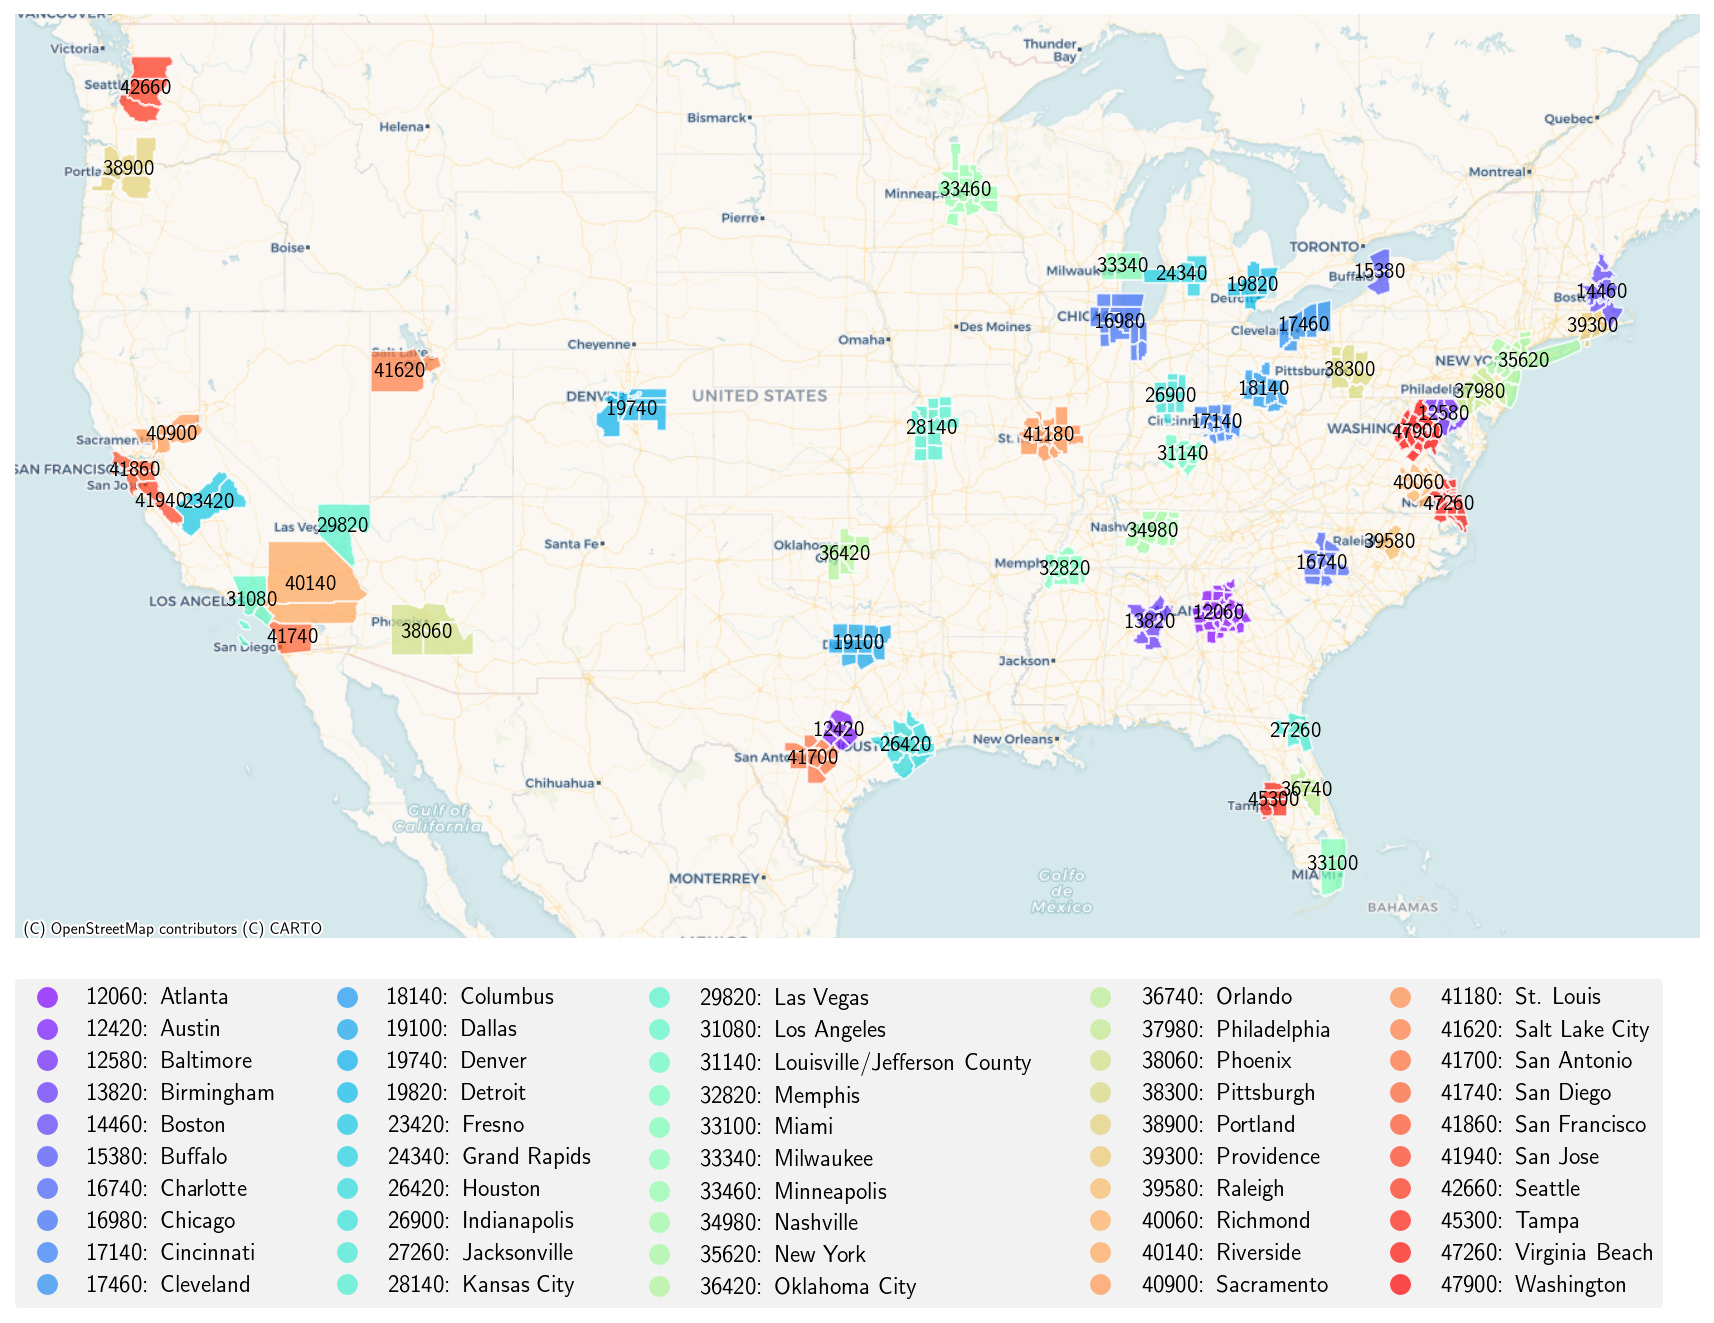

In [22]:
ax = U.plot(size=(20, 8), dpi=150, axoff=1)
msa20.plot(ax=ax, column='label', cmap='rainbow', alpha=0.7, ec='w', lw=1, 
           legend=True, legend_kwds=D(ncol=5, loc=(0, -0.4)))
for msa_id, df in msa20.groupby('cbsa_id'):
    cx, cy = list(df.dissolve().centroid.iloc[0].coords)[0]
    ax.text(cx, cy, msa_id, ha='center', va='center', 
            fontsize=10)
ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.CartoDB.Voyager)

In [23]:
# msa20.explore(column='cbsa', legend=False)